In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
soft = torch.nn.Softmax(dim=1)

### 'AbAcAd' RNNCell

In [3]:
txt = list('AbAcAd'*50)
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [4]:
#데이터 원핫인코딩.
df_train = pd.DataFrame({'x':txt[:-1],'y':txt[1:]})
x = torch.tensor(df_train['x'].map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train['y'].map({'A':0,'b':1,'c':2,'d':3}))

In [5]:
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [6]:
#네트워크 선언
torch.manual_seed(4)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4) #헷갈리지 말것.... 임베딩 스페이스 2차원,, 예측하고자 하는 라벨 4개

In [7]:
#손실함수와 옵티마이저 선언.
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters()) + list(cook.parameters()),lr = 0.1)

In [8]:
L = len(X)
for epoc in range(200):
  ## 1 + 2
  loss = 0
  ht = torch.zeros(2)
  for t in range(L):
    Xt, yt = X[t],y[t]
    ht = rnncell(Xt,ht)
    ot = cook(ht)
    loss = loss + loss_fn(ot,yt)
  loss = loss/L
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [9]:
#yhat을 구하자
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
  h[t] = rnncell(X[t],h[t-1])

yhat = soft(cook(h))

#### 결과 시각화

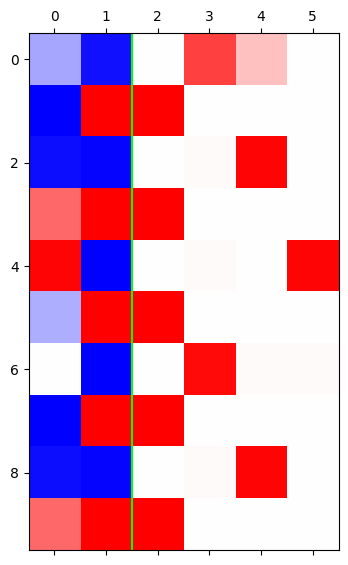

In [10]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.axvline(1.5,color = 'lime') #갈 수록 잘 맞춤

### 'AbAcAd' RNN

In [20]:
#같은 데이터로 진행
torch.manual_seed(4)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4) #2차원 임베딩 스페이스 -> 4차원 아웃풋 스페이스.

In [21]:
rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data #데이터 까먹지 마세용..;;

In [22]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()),lr = 0.1)

In [24]:
Water = torch.zeros(1,2) #RNN은 디멘션을 존중해줘야함....
for epoc in range(200):
  ##1
  h, hL = rnn(X,Water)
  netout = cook(h)
  ##2
  loss = loss_fn(netout,y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [26]:
h,_ = rnn(X,Water)

In [27]:
h.shape #229, dimension..

torch.Size([299, 2])

In [28]:
yhat = soft(cook(h))

#### 결과 시각화

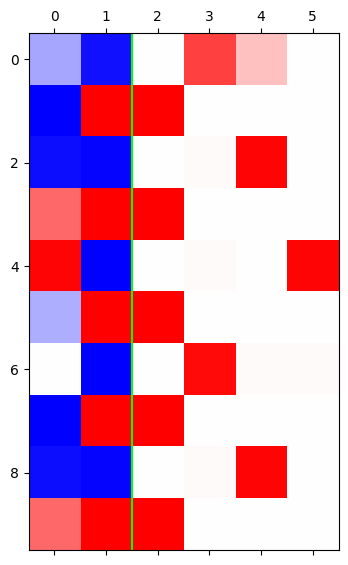

In [30]:
mat = torch.concat([h,yhat],axis =1).data[:10]
plt.matshow(mat,cmap = 'bwr',vmin = -1, vmax = 1)
plt.axvline(1.5,color='lime')


### 'AbAcAd' RNN + GPU

In [31]:
#### 데이터, 손실함수와 옵티마이저 기본 세팅
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

torch.manual_seed(4)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [34]:
X = X.to("cuda:0")
y = y.to("cuda:0")
rnn = rnn.to("cuda:0")
cook = cook.to("cuda:0")
Water = torch.zeros(1,2).to("cuda:0")

for epoc in range(200):
  ##1
  h,hL = rnn(X,Water)
  netout = cook(h)
  ##2
  loss = loss_fn(netout, y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [35]:
h,_ = rnn(X,Water)

In [36]:
yhat = soft(cook(h))

#### 결과 시각화

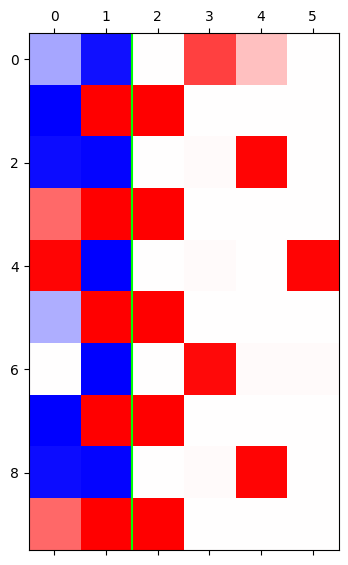

In [38]:
mat = torch.concat([h,yhat],axis=1).data[:10].to("cpu")
plt.matshow(mat,cmap = 'bwr',vmin = -1, vmax = 1)
plt.axvline(1.5,color='lime')

### 'AbAcAd' RNN + GPU + 초기값(맹물) 생략

In [39]:
#### 데이터, 손실함수와 옵티마이저 기본 세팅
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

torch.manual_seed(4)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [40]:
X = X.to("cuda")
y = y.to("cuda")
rnn = rnn.to("cuda")
cook = cook.to("cuda")

In [41]:
for epoc in range(200):
  ##1
  h,hL = rnn(X) #초기값 없지렁~
  netout = cook(h)
  ##2
  loss = loss_fn(netout, y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [42]:
h,_ = rnn(X)
yhat = soft(cook(h))

#### 결과 시각화

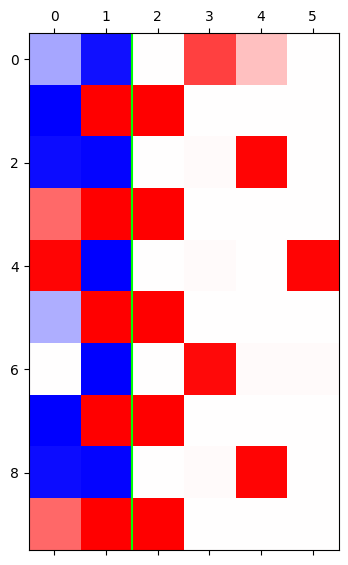

In [43]:
mat = torch.concat([h,yhat],axis = 1).data[:10].to("cpu")
plt.matshow(mat,cmap='bwr',vmin = -1,vmax = 1)
plt.axvline(1.5,color= 'lime')

### 은닉층 노드 수에 따른 성능

#### 2개

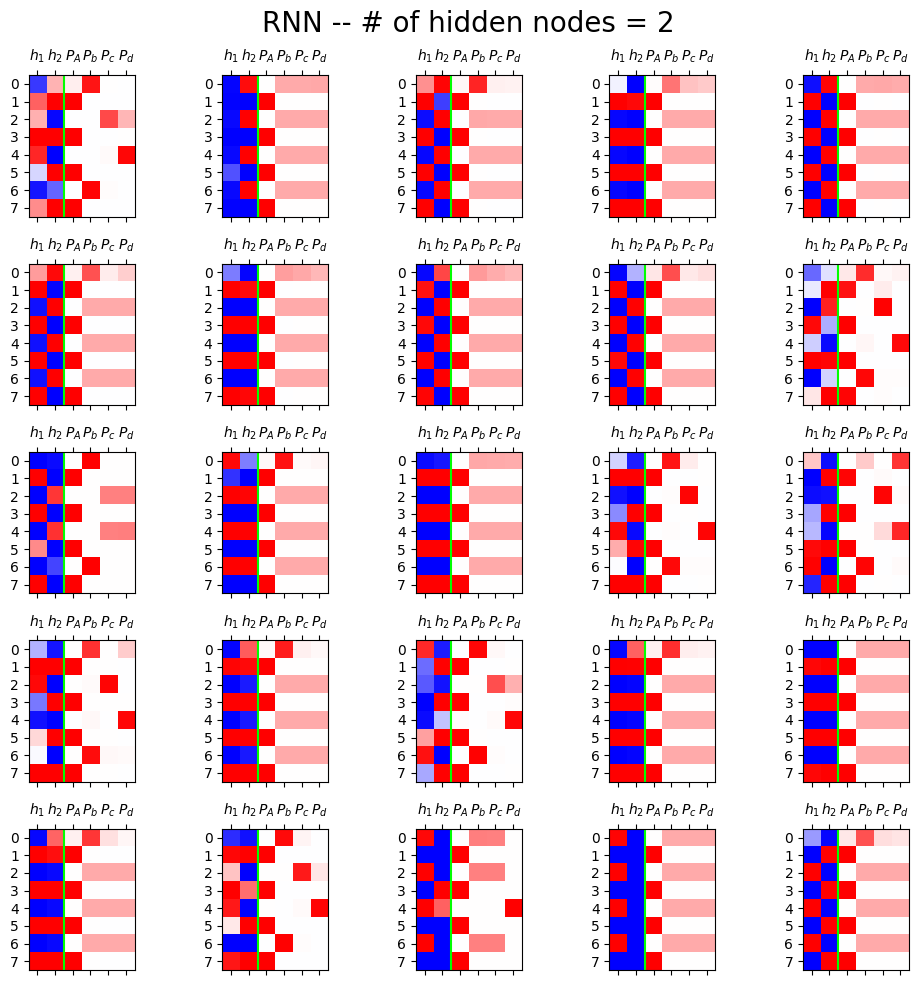

In [44]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3})) #h가 은닉노드..
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,2).to("cuda:0")
        cook = torch.nn.Linear(2,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu") #rnn의 첫번째 원소.. 언패킹 했던거 기억할 것..
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=1.5,color="lime")
        ax[i][j].set_xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 2",size=20)
fig.tight_layout()

#학습이 잘 된 부분하고 잘 안된 부분을 구별하는 특징이 있는데... 학습이 잘 된 경우는 임베딩 스페이스에 채도가 낮은 부분이 있다..
#쨍할 수록 구분이 잘 되는건 맞지만 ,, 그건 구분을 잘 해야하는 경우의 문제고,.
#이렇게 임베딩 스페이스에 넘치게 학습을 시킨경우, 색상차이가 얼마 나지 않는것을 캐치하는 것이 중요하다.
#스몰 b,c,d는 별로 중요하지 않았다는 포인트를 기억할 것.

#### 3개

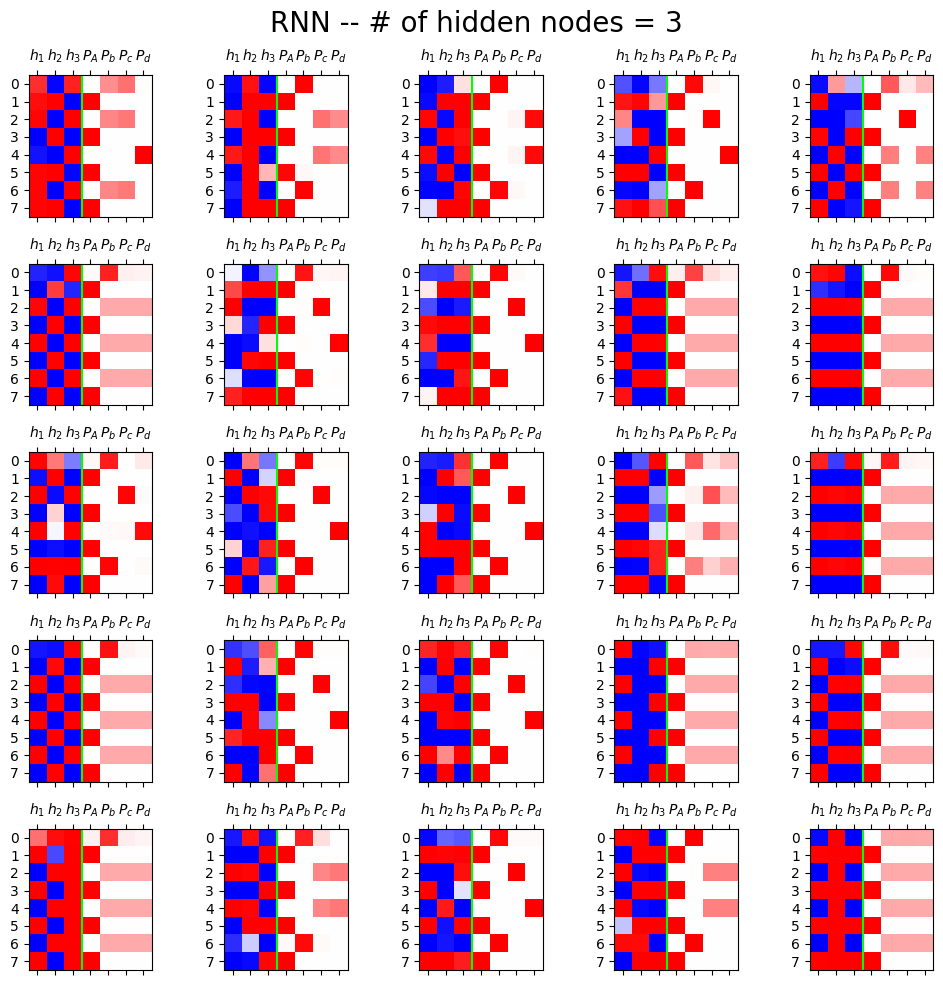

In [45]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,3).to("cuda:0")
        cook = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=2.5,color="lime")
        ax[i][j].set_xticks(range(7),[r'$h_1$',r'$h_2$',r'$h_3$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 3",size=20)
fig.tight_layout()

#임베딩 스페이스를 discrete하게 쓰려는 경우(딱딱 떨어지게) 학습이 실패하는 경우가 잦다.. 미세하게 잘 쓰지 못함
#임베딩 스페이스를 Continuous 하게 쓰려는 경우 학습이 잘 되는 경우가 많다.
#굳이 이러고 싶지 않으면 임베딩 스페이스를 넓게 잡아주면 됨. 다음 예시가 그러함.

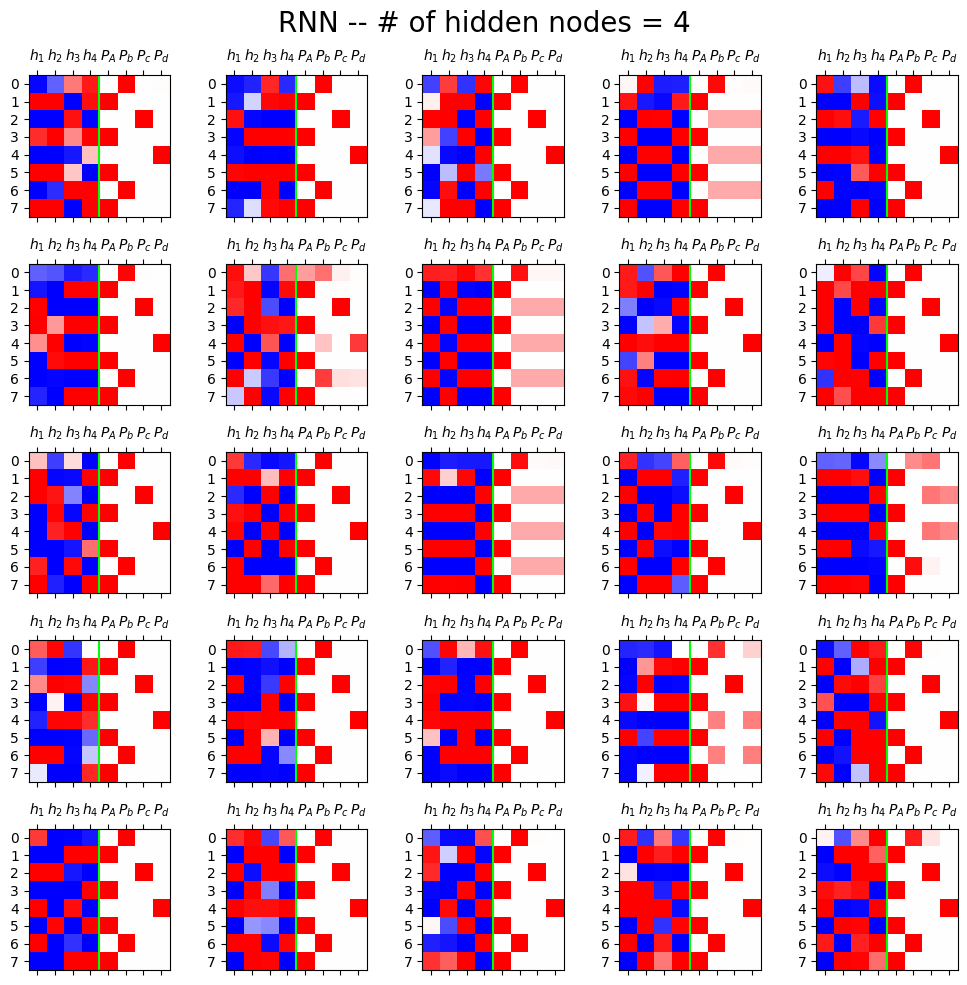

In [46]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,4).to("cuda:0")
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 4",size=20)
fig.tight_layout()
#임베딩 스페이스를 넓게 쓰면.. (차원 많으면) 가중치를 -1 or 1 로 몰아주려는 경향이 생긴다...
#임베딩 스페이스를 좁게 써야 잘 쓰는건데..
#어떻게 해야 좁게 잘 쓰지? LSTM

### 'abcabC'

#### with RNN(# hidden node = 2) $\to$ failed

In [47]:
txt = list('abcabC'*50)

In [50]:
df_train = pd.DataFrame({'x':txt[:-1],'y':txt[1:]})
x = torch.tensor(df_train['x'].map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train['y'].map({'a':0,'b':1,'c':2,'C':3}))
x = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [51]:
rnn = torch.nn.RNN(4,2)
cook = torch.nn.Linear(2,4)

loss = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()),lr = 0.1)

In [52]:
x = x.to("cuda:0")
y = y.to("cuda:0")
rnn = rnn.to("cuda:0")
cook = cook.to("cuda:0")

In [53]:
for epoc in range(200):
  ##1
  h,_ = rnn(x)
  netout = cook(h)
  ##2
  loss = loss_fn(netout, y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [54]:
h,_ = rnn(x)
yhat = soft(cook(h))

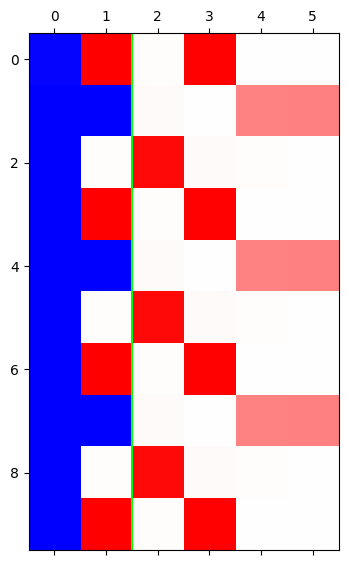

In [56]:
mat = torch.concat([h,yhat],axis=1).data[:10].to("cpu")
plt.matshow(mat, cmap = 'bwr', vmin = -1, vmax = 1)
plt.axvline(1.5,color = 'lime') #c랑 C 구분 못함.

#### with RNN(# hidden node = 3) $\to$ failed

In [57]:
df_train = pd.DataFrame({'x':txt[:-1],'y':txt[1:]})
x = torch.tensor(df_train['x'].map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train['y'].map({'a':0,'b':1,'c':2,'C':3}))
x = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [58]:
rnn = torch.nn.RNN(4,3)
cook = torch.nn.Linear(3,4)

loss = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()),lr = 0.1)

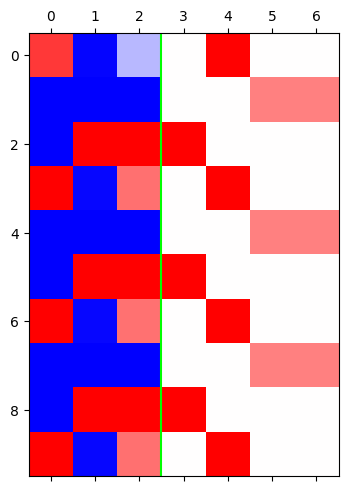

In [59]:
x = x.to("cuda:0")
y = y.to("cuda:0")
rnn = rnn.to("cuda:0")
cook = cook.to("cuda:0")

for epoc in range(200):
  ##1
  h,_ = rnn(x)
  netout = cook(h)
  ##2
  loss = loss_fn(netout, y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

h,_ = rnn(x)
yhat = soft(cook(h))

mat = torch.concat([h,yhat],axis=1).data[:10].to("cpu")
plt.matshow(mat, cmap = 'bwr', vmin = -1, vmax = 1)
plt.axvline(2.5,color = 'lime') #c랑 C 구분 못함.

### Alternative : LSTM

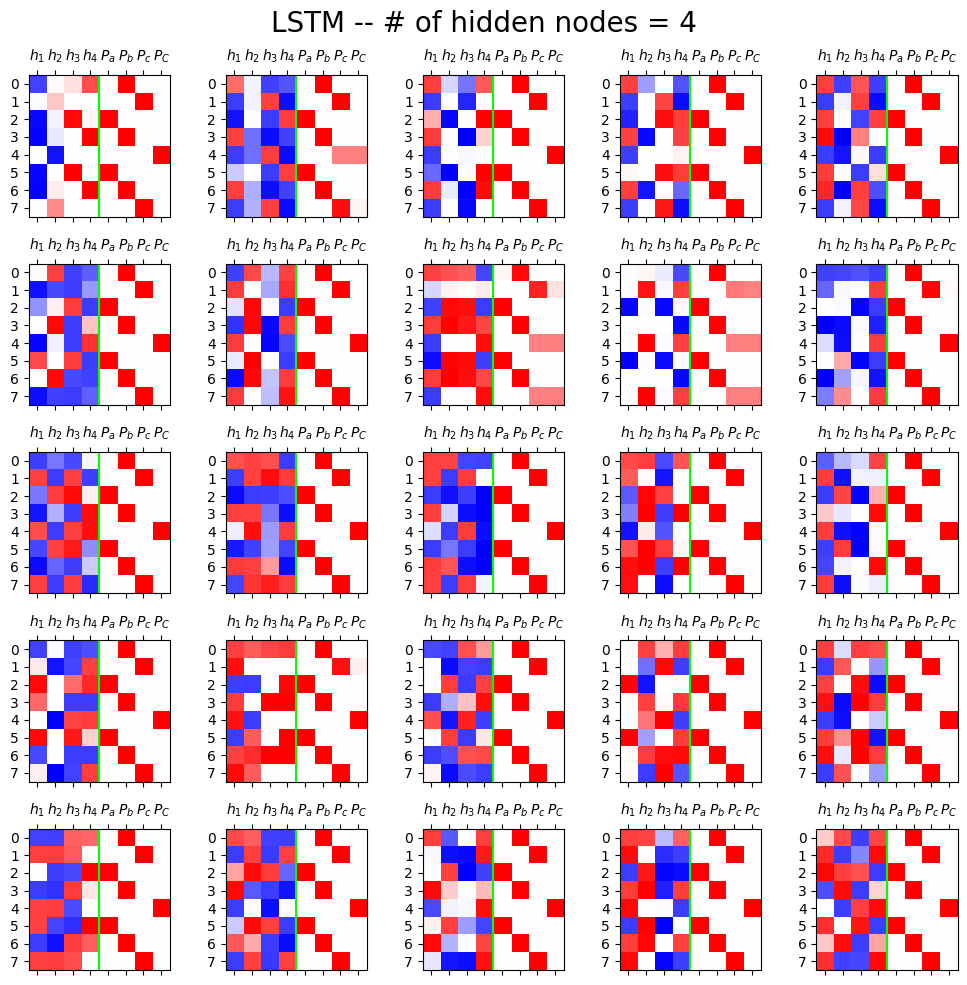

In [60]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(4,4).to("cuda:0") #RNN -> LSTM으로 바뀜
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(500):
            ## 1
            h,_ = lstm(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = lstm(X)[0].data.to("cpu")
        yhat = soft(cook(lstm(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr",vmin=-1,vmax=1)
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_C$'])
fig.suptitle("LSTM -- # of hidden nodes = 4",size=20)
fig.tight_layout()
#임베딩 스페이스를 아주 자잘자잘하게 쓰는중... 좀더 많은 문자열에 대해서도 4개의 은닉노드 갖고 할 수 있을 거 같음.
#아니면 같은 문자열에 대해 하나정도 더 적은 은닉노드로?

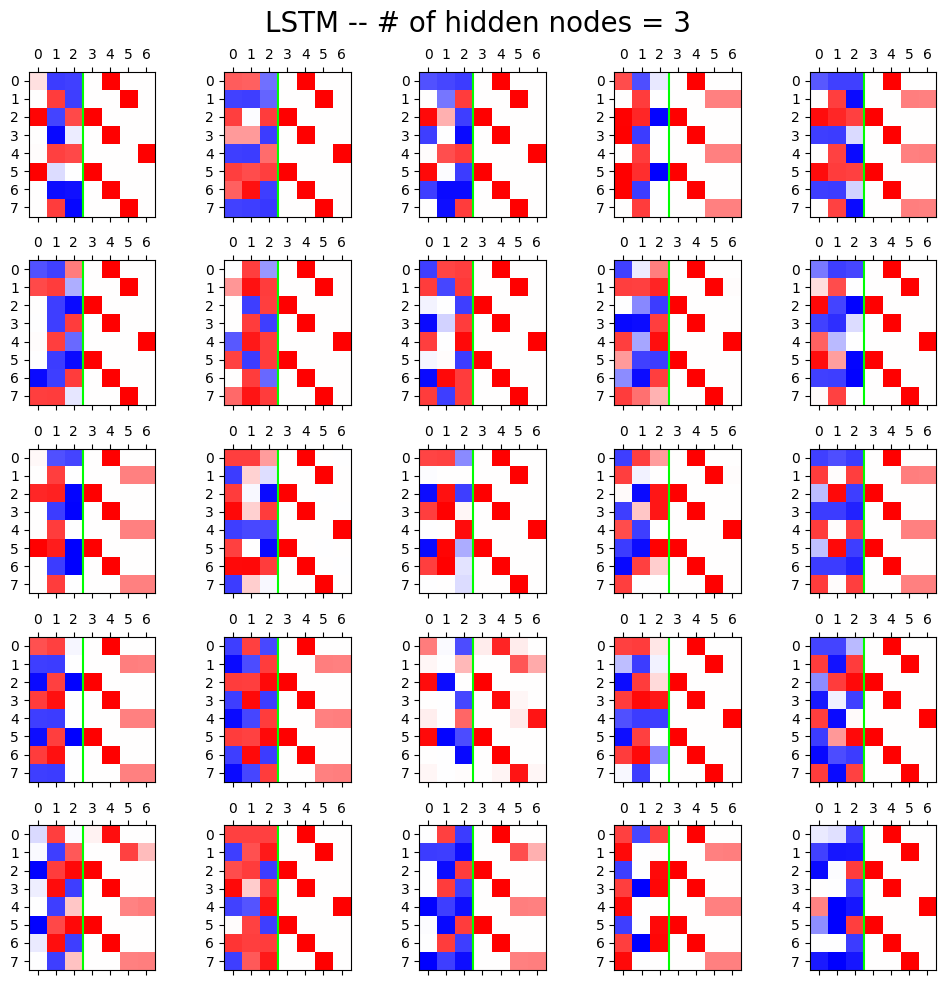

In [62]:
#LSTM 은닉노드수 3
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(4,3).to("cuda:0") #RNN -> LSTM으로 바뀜
        cook = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(500):
            ## 1
            h,_ = lstm(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = lstm(X)[0].data.to("cpu")
        yhat = soft(cook(lstm(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr",vmin=-1,vmax=1)
        ax[i][j].axvline(x=2.5,color="lime")
        #ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_C$'])
fig.suptitle("LSTM -- # of hidden nodes = 3",size=20)
fig.tight_layout()
#예측 못하는 경우도 있긴 한데 그래도 RNN 쓸 때 보다 훨 나음.